# Homework 8.  Douglas Drake


In [1]:
# import dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Use inspect to examine the tables
from sqlalchemy import inspect

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types for the measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types for the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# One way to get the first date and last dates in the database

query_results = session.query(func.min(Measurement.date), func.max(Measurement.date)).all()

for min_date, max_date in query_results:
    print(f"The earliest date in the table is: {min_date}")
    print(f"The latest date in the table is: {max_date}")
    print(f"The dates are stored as type: {type(min_date)}")

The earliest date in the table is: 2010-01-01
The latest date in the table is: 2017-08-23
The dates are stored as type: <class 'str'>


In [14]:
# Another way to get the first and last dates in the datebase
# Using order_by
date_range = [(session.query(Measurement.date).order_by(Measurement.date).first()[0],\
              session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0])]

for min_date, max_date in date_range:
    print(f"The earliest date in the table is: {min_date}")
    print(f"The latest date in the table is: {max_date}")
    print(f"The dates are stored as type: {type(min_date)}")

The earliest date in the table is: 2010-01-01
The latest date in the table is: 2017-08-23
The dates are stored as type: <class 'str'>


## Precipitation Analysis

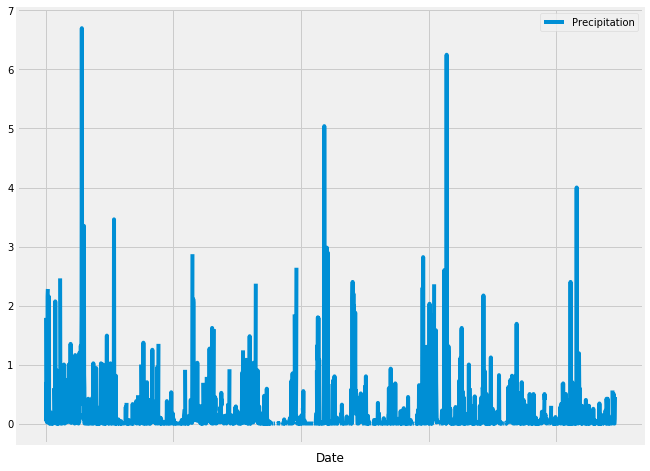

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# pull the last date and convert to a datetime object
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
# For longer timespans we would need to use dateutil.relativedelta to handle leap years
one_year_ago = last_date - dt.timedelta(days=365)
one_year_ago_str = one_year_ago.strftime("%Y-%m-%d")

# We take our query date back to a string because comparisons 
# using a datetime object version of the date give a slightly different result
# I have commented out the datetime version of the query - it returns 7 fewer observations

# Perform a query to retrieve the data and precipitation scores
last_years_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_str).all()
# print(f"The length of the pull is: {len(last_years_data)}")
# The length of the pull is: 2230

#last_years_data_dt = session.query(Measurement.date, Measurement.prcp).\
#    filter(Measurement.date >= one_year_ago).all()
#print(f"The length of the pull is: {len(last_years_data_dt)}")
# The length of the pull is: 2223
# Inspecting the query shows that none of the dates for 2016-08-23 are included

# Sort the dataframe by date
df_str = pd.DataFrame(last_years_data, columns=["Date", "Precipitation"])
df_str.set_index('Date', inplace=True)
df_str.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df_str.plot(figsize=(10,8))

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df_str.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [17]:
# Design a query to show how many stations are available in this dataset?
# We could list all of the unique stations and find the length of the query:
query_results = session.query(Measurement.station).distinct().all()

for row in query_results:
    print(row)
print(f"The number of stations in the measurement table: {len(query_results)}")

# Or we could just count them in the query
from sqlalchemy import distinct
session.query(func.count(distinct(Measurement.station))).scalar()

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)
The number of stations in the measurement table: 9


9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# The most active station: assign a reference to this result for later use

most_active = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

most_active

'USC00519281'

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

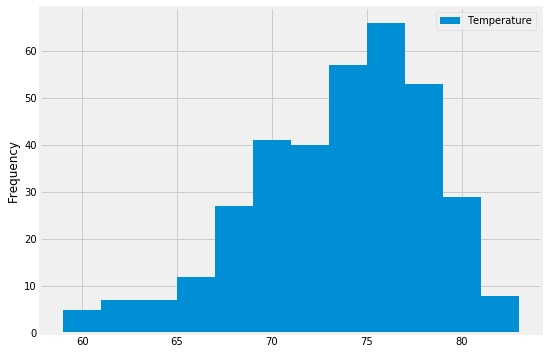

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_results = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago_str).\
    filter(Measurement.station == most_active).all()

#query_results[:10]
df_temp = pd.DataFrame(query_results, columns=['Temperature'])
df_temp.plot.hist(bins=12, figsize=(8,6)) # default is bins=10, bins=12 matches the sample graph

# Optional: Other Recommended Analyses

## Temperature Analysis

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

# The output in the starter notebook was produced using the date range 2017-01-01 to 2017-01-07
print(calc_temps('2017-01-01', '2017-01-07'))

[(62.0, 69.57142857142857, 74.0)]
[(62.0, 68.36585365853658, 74.0)]


In [23]:
# A helper function
def one_year_ago(a_date, date_format="%Y-%m-%d", return_datetime=False):
    """
    Args: 
        a_date:  
            is a string representation of a date with the time-format specified in date_format 
            (default is %Y-%m-%d)
        date_format: 
            the format of a_date
        return_datetime:
            specifies whether the result should be returned as a string (the default) or a 
            datetime object.
            
    Returns: (Default) a string object that is the date one-year prior to a_date in the same format as
        a_date or a datetime object if return_datetime is True 
    """
    a_date = dt.datetime.strptime(a_date, date_format)
    one_year_prior = a_date - dt.timedelta(days=365)
    if return_datetime:
        return one_year_prior
    else:
        return one_year_prior.strftime(date_format)

# An example of the above function: 
start_date = "2018-01-01"
start_delta_dt = one_year_ago(start_date, return_datetime=True)
start_delta_str = one_year_ago(start_date)

print(f"Date: {start_date}")
print(f"Date one-year-prior (as a datetime object): {start_delta_dt}")
print(f"Date one-year-prior (as string): {start_delta_str}")


Date: 2018-01-01
Date one-year-prior (as a datetime object): 2017-01-01 00:00:00
Date one-year-prior (as string): 2017-01-01


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Pick a startind and ending date for the trip:
start_date = '2018-03-05'
end_date = '2018-03-12'

start_delta = one_year_ago(start_date)
end_delta = one_year_ago(end_date)
temps = calc_temps(start_delta, end_delta)
temps

[(62.0, 70.34042553191489, 82.0)]

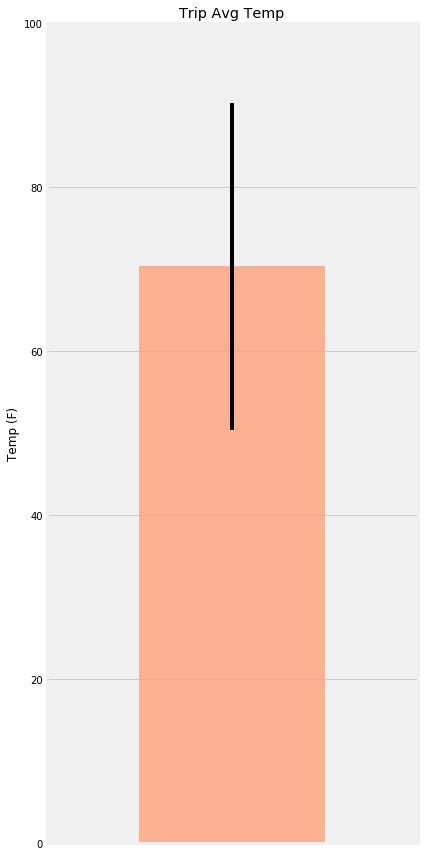

In [25]:
# Plotting the results for our trip dates:

yerr = [max(temps[0])-min(temps[0])]

df_summary_temps = pd.DataFrame(temps, columns = ['tmin', 'tavg', 'tmax'])
ax = df_summary_temps['tavg'].plot(kind='bar',yerr=yerr,color="lightsalmon",figsize=(6,12),alpha=0.8)
ax.set_title('Trip Avg Temp')
ax.set_xticklabels([])
ax.set_ylabel('Temp (F)')
ax.xaxis.grid(False)
ylim = [0, 100]
ax.set_ylim(0,100)

# Save the figure and show
plt.tight_layout()
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

query_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_delta).\
    filter(Measurement.date <= end_delta).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for row in query_results:
    print(row)

('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.57)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.13)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.63)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.36)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.35)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)


##  Why we do not see data for nine stations:
An earlier query identified nine stations in the measurement table.  The last query only returned information on seven stations.  We use the following query to see that two of the stations (USC00511918 and USC00518838) stopped supplying observations in 2015.  Queries using other date ranges may supply differing numbers of results depending on whether a station was reporting in that date range.

In [27]:
# The following query gets at the heart of the problem.  We do not have observations after 2016 for two of the stations.

sel = [Station.station,
       Station.name,
       func.min(Measurement.date),
       func.max(Measurement.date)]

query_results = session.query(*sel).\
    join(Measurement, Measurement.station == Station.station, isouter=True).\
    group_by(Station.station).\
    order_by(func.max(Measurement.date)).all()

for row in query_results:
    print(row)

('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', '2010-01-01', '2015-10-30')
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', '2010-01-01', '2015-11-20')
('USC00513117', 'KANEOHE 838.1, HI US', '2010-01-01', '2017-07-31')
('USC00517948', 'PEARL CITY, HI US', '2010-05-03', '2017-07-31')
('USC00519281', 'WAIHEE 837.5, HI US', '2010-01-01', '2017-08-18')
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', '2010-03-01', '2017-08-23')
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', '2010-01-01', '2017-08-23')
('USC00519397', 'WAIKIKI 717.2, HI US', '2010-01-01', '2017-08-23')
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', '2010-01-01', '2017-08-23')


## Daily Rainfall Average

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:

# We can loop over the dates to create the required date strings

# convert our trip dates to datetime objects
start_date_dt = dt.datetime.strptime(start_date, "%Y-%m-%d")
end_date_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")


trip_dates = []
dates = []
current_date = start_date_dt

while (current_date <= end_date_dt):
        trip_dates.append(current_date.strftime("%Y-%m-%d"))
        dates.append(current_date.strftime("%m-%d"))
        current_date = current_date + dt.timedelta(days=1)

print(trip_dates)
print(dates)

# Now use a list comprehension to get the requested daily normals
normals = [daily_normals(date)[0] for date in dates]

for row in normals:
    print(row)


['2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12']
['03-05', '03-06', '03-07', '03-08', '03-09', '03-10', '03-11', '03-12']
(60.0, 67.89090909090909, 76.0)
(60.0, 69.20338983050847, 76.0)
(60.0, 69.17241379310344, 78.0)
(59.0, 68.72413793103448, 78.0)
(57.0, 68.56140350877193, 75.0)
(57.0, 69.12280701754386, 75.0)
(60.0, 69.89285714285714, 82.0)
(62.0, 69.88888888888889, 80.0)


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df['date'] = trip_dates
normals_df.set_index('date', inplace=True)
normals_df

,tmin,tavg,tmax
date,,,
2018-03-05,60.0,67.890909,76.0
2018-03-06,60.0,69.203390,76.0
2018-03-07,60.0,69.172414,78.0
2018-03-08,59.0,68.724138,78.0
2018-03-09,57.0,68.561404,75.0
2018-03-10,57.0,69.122807,75.0
2018-03-11,60.0,69.892857,82.0
2018-03-12,62.0,69.888889,80.0


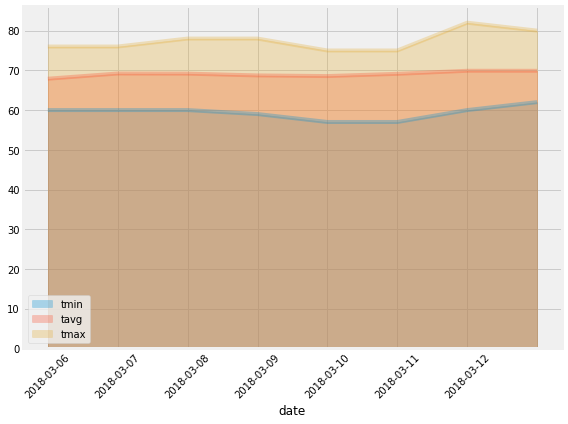

In [31]:
# Plot the daily normals as an area plot with `stacked=False`

ax = normals_df.plot.area(stacked=False, alpha = 0.3, figsize=(8,6))
ax.set_xticklabels(normals_df.index, rotation=45)
plt.tight_layout()
#plt.xticks(rotation=45)